In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

d:\Program Files (x86)\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [3]:
dates     = pd.date_range('2010-10-11','2017-10-11',freq = 'B')
df_main   = pd.DataFrame(index = dates)
df_aaxj   = pd.read_csv("data_stock/ETFs/aaxj.us.txt", parse_dates=True, index_col=0)
df_main   = df_main.join(df_aaxj)

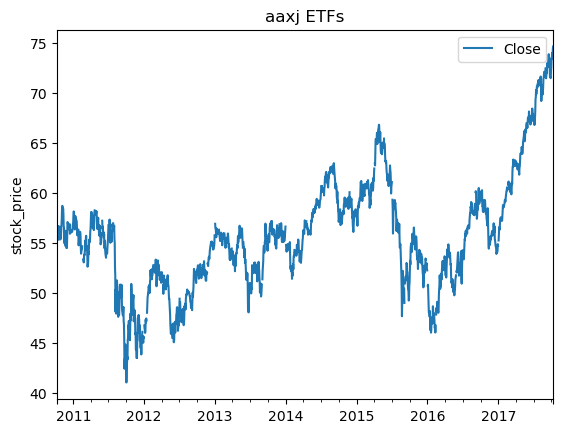

In [4]:
df_main[['Close']].plot()
plt.ylabel("stock_price")
plt.title("aaxj ETFs")
plt.show()

In [5]:
df_main

,Open,High,Low,Close,Volume,OpenInt
2010-10-11,55.971,56.052,55.863,56.052,268544.0,0.0
2010-10-12,55.676,55.792,55.362,55.667,817951.0,0.0
2010-10-13,56.472,56.867,56.401,56.569,999413.0,0.0
2010-10-14,56.733,56.742,56.293,56.579,661897.0,0.0
2010-10-15,56.893,56.893,56.194,56.552,245001.0,0.0
...,...,...,...,...,...,...
2017-10-05,73.500,74.030,73.500,73.970,2134323.0,0.0
2017-10-06,73.470,73.650,73.220,73.579,2092100.0,0.0
2017-10-09,73.500,73.795,73.480,73.770,879600.0,0.0
2017-10-10,74.150,74.490,74.150,74.480,1878845.0,0.0


In [6]:
sel_col = ['Open', 'High', 'Low', 'Close']
df_main = df_main[sel_col]
df_main.head()

,Open,High,Low,Close
2010-10-11,55.971,56.052,55.863,56.052
2010-10-12,55.676,55.792,55.362,55.667
2010-10-13,56.472,56.867,56.401,56.569
2010-10-14,56.733,56.742,56.293,56.579
2010-10-15,56.893,56.893,56.194,56.552


In [7]:
df_main = df_main.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
for col in sel_col:
    df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))

In [8]:
df_main['target'] = df_main['Close'].shift(-1) 
df_main.dropna()
df_main = df_main.astype(np.float32)

In [9]:
def create_seq_data(data_raw,seq):
    data_feat,data_target = [],[]
    for index in range(len(data_raw) - seq):
        data_feat.append(data_raw[['Open', 'High', 'Low', 'Close']][index: index + seq].values)
        data_target.append(data_raw['target'][index:index + seq])
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)
    return data_feat,data_target

def train_test(data_feat,data_target,test_set_size,seq):
    train_size = data_feat.shape[0] - (test_set_size) 
    trainX = torch.from_numpy(data_feat[:train_size].reshape(-1,seq,4)).type(torch.Tensor)
    testX  = torch.from_numpy(data_feat[train_size:].reshape(-1,seq,4)).type(torch.Tensor)
    trainY = torch.from_numpy(data_target[:train_size].reshape(-1,seq,1)).type(torch.Tensor)
    testY  = torch.from_numpy(data_target[train_size:].reshape(-1,seq,1)).type(torch.Tensor)
    return trainX,trainY,testX,testY

In [10]:
data_raw = df_main
seq = 20
test_set_size = int(np.round(0.2*data_raw.shape[0]))
# generate train & test dataset
feat,target = create_seq_data(data_raw,seq)
trainX,trainY,testX,testY = train_test(feat,target,test_set_size,seq)

In [11]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([1442, 20, 4])
y_train.shape =  torch.Size([1442, 20, 1])
x_test.shape =  torch.Size([366, 20, 4])
y_test.shape =  torch.Size([366, 20, 1])


In [12]:
n_steps = seq
batch_size = 1442
num_epochs = 100

In [13]:
train = torch.utils.data.TensorDataset(trainX,trainY)
test = torch.utils.data.TensorDataset(testX,testY)
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [14]:
# Build model
#####################
input_dim = 4
hidden_dim = 32
num_layers = 2 
output_dim = 1
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out) 
        # out.size() --> 100, 10
        return out
    

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 4])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


d:\Program Files (x86)\Anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [16]:
# train model
hist = np.zeros(num_epochs)
seq_dim = seq
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(trainX)

    loss = loss_fn(y_train_pred, trainY)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.016249079257249832
Epoch  20 MSE:  0.009414547123014927
Epoch  30 MSE:  0.005053506698459387
Epoch  40 MSE:  0.003611801192164421
Epoch  50 MSE:  0.002900585299357772
Epoch  60 MSE:  0.0024391543120145798
Epoch  70 MSE:  0.0021094006951898336
Epoch  80 MSE:  0.0018927097553387284
Epoch  90 MSE:  0.0017709947424009442


In [17]:
p = y_train_pred.detach().numpy()[:,-1,0]
trainY_target = trainY.detach().numpy()[:,-1,0]

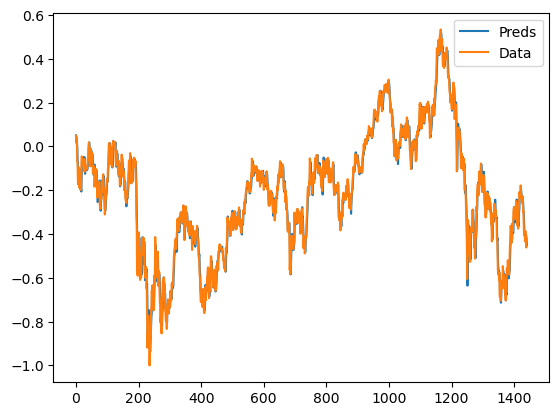

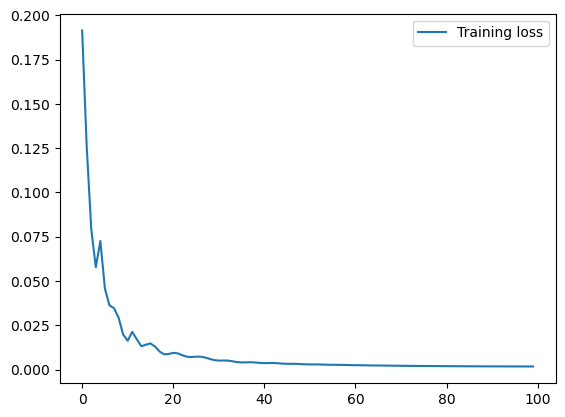

In [18]:
plt.plot(p, label="Preds")
plt.plot(trainY_target, label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [19]:
# make predictions
y_test_pred = model(testX)
y_train_pred.detach().numpy()[:,-1,0]

array([ 0.05065462,  0.04744147,  0.03317844, ..., -0.40832764,
       -0.45232415, -0.4271853 ], dtype=float32)

In [20]:
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()[:,-1,0].reshape(-1,1))
y_train = scaler.inverse_transform(trainY.detach().numpy()[:,-1,0].reshape(-1,1))
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()[:,-1,0].reshape(-1,1))
y_test = scaler.inverse_transform(testY.detach().numpy()[:,-1,0].reshape(-1,1))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.67 RMSE
Test Score: 0.73 RMSE


In [21]:
df_test_final = pd.DataFrame(y_test,columns = ['y_test']).join(pd.DataFrame(y_test_pred,columns = ['y_test_pred']))

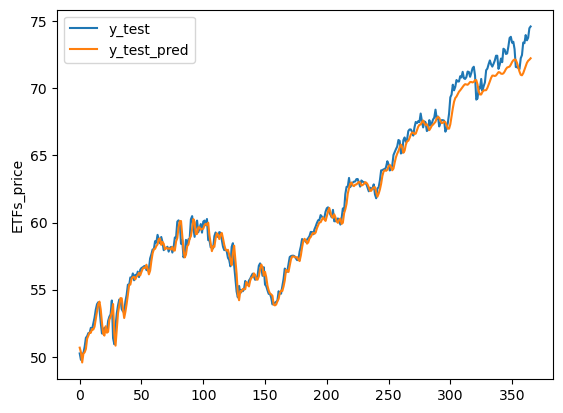

In [22]:
df_test_final[['y_test', 'y_test_pred']].plot()
plt.ylabel("ETFs_price")
plt.show()